<a href="https://colab.research.google.com/github/Jackson00Han/Time-Series-Training/blob/main/Univariate_Time_Series_With_Exogenous_Variables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Univariate Time Series Forecasting With Exogenous Variables

## Introduction
This is an example of a univariate time series with exogenous variables.

In this project, we assume that the future values of other variables, except for PM2.5, can be forecasted. Therefore, these variables are considered exogenous. PM2.5 is the target variable.



**Data Info:**


No: This is the row number or record index.

year: The year of the observation, in this example it is 2010.

month: The month of the observation, in this case, January.

day: The day of the observation, indicating the specific day of the month.

hour: The hour of the observation, using a 24-hour format (e.g., 0 represents midnight, 1 represents 1 AM).

pm2.5: The concentration of PM2.5 (fine particulate matter) in the air, possibly measured in micrograms per cubic meter (μg/m³). In this data segment, some values are missing (denoted as NA).

DEWP: Dew point temperature in degrees Celsius (°C), which indicates the temperature at which air becomes saturated and dew forms.

TEMP: The actual air temperature, measured in degrees Celsius (°C).

PRES: Atmospheric pressure, measured in hectopascals (hPa).

cbwd: Coded wind direction, shown as abbreviations like NW for northwest wind.

Iws: Cumulative wind speed, possibly measured in meters per second (m/s).

Is: Cumulative precipitation, possibly measured in millimeters (mm). In this data segment, all values are 0, indicating no precipitation.

Ir: Cumulative snowfall, possibly measured in millimeters (mm). In this data segment, all values are 0, indicating no snowfall.

## Set Up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('pollution.csv')
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


## Data Preprocessing

In [3]:
# Convert numeric columns to strings before concatenation
df['datetime'] = df['year'].astype(str) + '-' + df['month'].astype(str) + '-' + \
                 df['day'].astype(str) + ' ' + df['hour'].astype(str) + ':00'

df['datetime'] = pd.to_datetime(df['datetime'])
df.drop(['year', 'month', 'day', 'hour'], axis=1, inplace=True)
df.set_index('datetime', inplace=True)

# Only use the last two years's data
df = df.loc[df.index > '2012-12-31 23']
df.drop(['No'], axis=1, inplace=True)
df.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
datetime,,,,,,,,
2013-01-01 00:00:00,35.0,-10,-5.0,1018.0,NW,5.81,0,0
2013-01-01 01:00:00,31.0,-11,-7.0,1017.0,NW,9.83,0,0
2013-01-01 02:00:00,32.0,-11,-7.0,1017.0,NW,11.62,0,0
2013-01-01 03:00:00,21.0,-14,-10.0,1018.0,NW,14.75,0,0
2013-01-01 04:00:00,16.0,-15,-10.0,1018.0,cv,0.45,0,0


In [4]:
df.isnull().sum()

,0
pm2.5,181
DEWP,0
TEMP,0
PRES,0
cbwd,0
Iws,0
Is,0
Ir,0


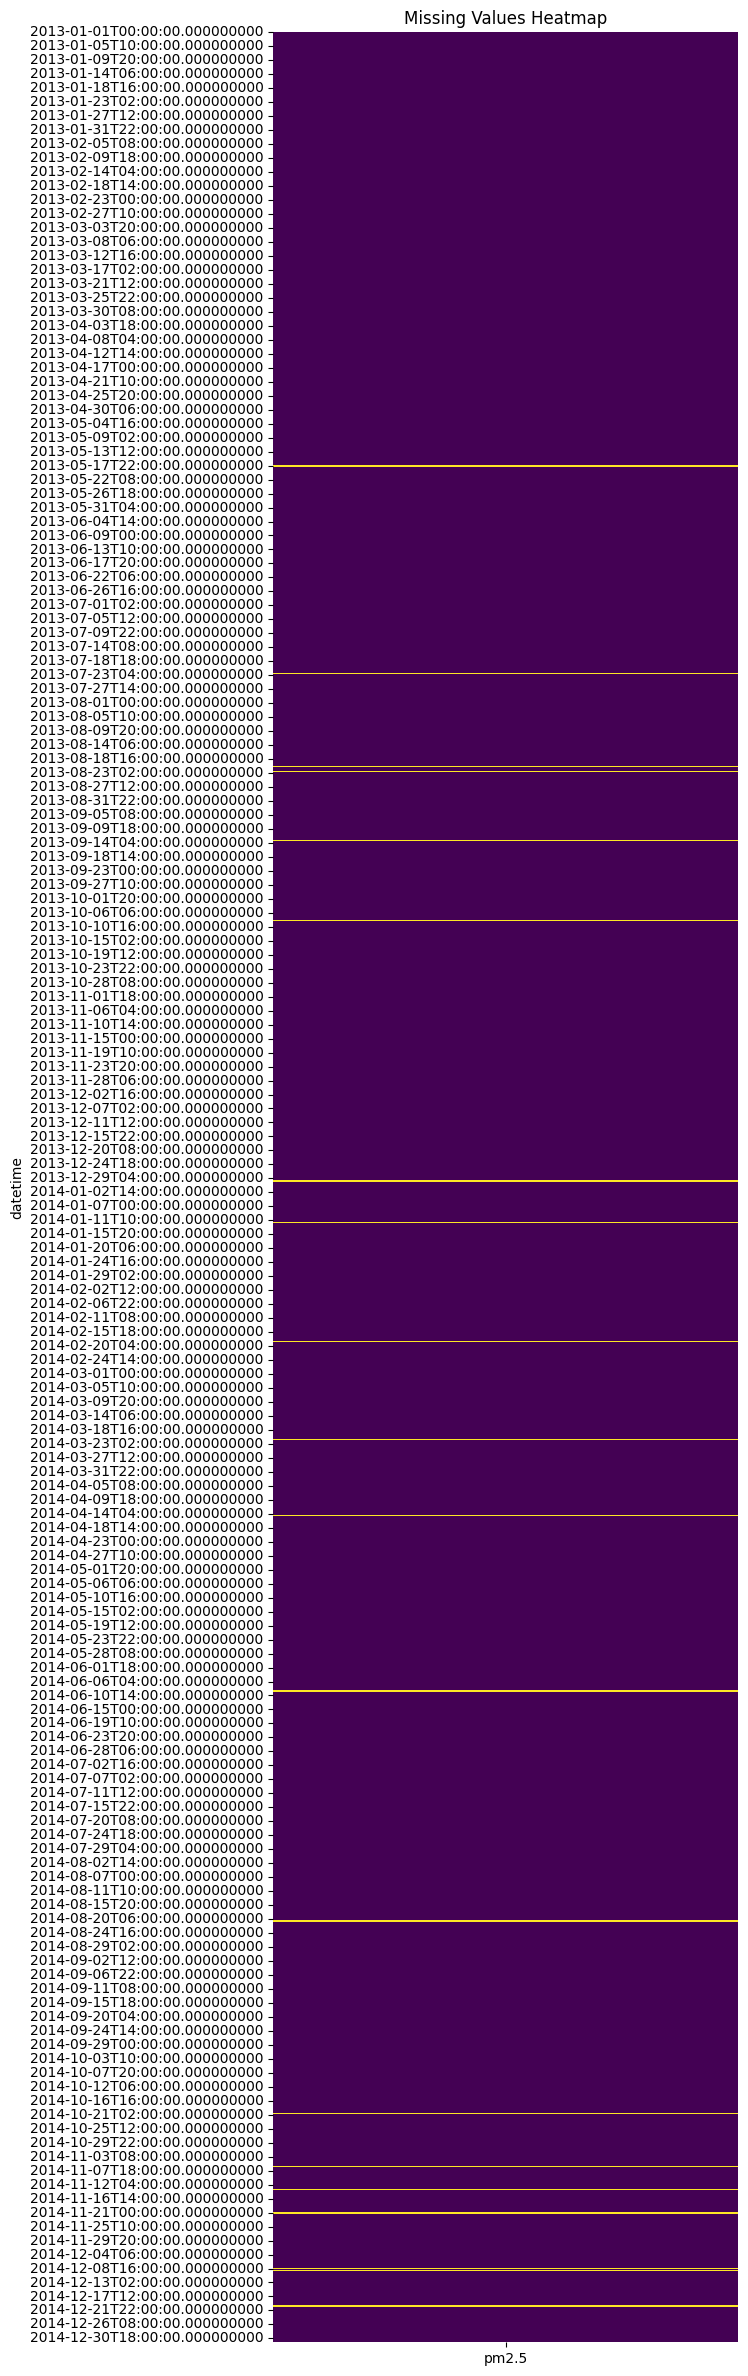

In [5]:
# visualize the missing values again
plt.figure(figsize=(6,30))
sns.heatmap(df['pm2.5'].isnull().to_frame(), cbar=False, cmap='viridis')  # Convert Series to DataFrame
plt.title('Missing Values Heatmap')
plt.show()

In [6]:
# Dealing with missing values
df['pm2.5'].interpolate(method='linear', inplace=True)

In [7]:
# One-Hot Encoding
df = pd.get_dummies(df, columns=['cbwd'], drop_first=True)

df[['cbwd_NW', 'cbwd_SE', 'cbwd_cv']] = df[['cbwd_NW', 'cbwd_SE', 'cbwd_cv']].astype(int)


# Statistics
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
pm2.5,17520.0,99.800000,95.929345,2.00,30.00,72.00,135.00,886.00
DEWP,17520.0,1.690925,14.274325,-40.00,-10.00,2.00,15.00,26.00
TEMP,17520.0,13.039384,11.857635,-17.00,3.00,14.00,23.00,42.00
PRES,17520.0,1016.218579,10.154897,991.00,1008.00,1016.00,1025.00,1046.00
Iws,17520.0,20.337931,45.887481,0.45,1.79,4.92,18.32,490.38
Is,17520.0,0.034418,0.594332,0.00,0.00,0.00,0.00,23.00
Ir,17520.0,0.148288,1.108909,0.00,0.00,0.00,0.00,25.00
cbwd_NW,17520.0,0.295034,0.456071,0.00,0.00,0.00,1.00,1.00
cbwd_SE,17520.0,0.358847,0.479676,0.00,0.00,0.00,1.00,1.00
cbwd_cv,17520.0,0.228653,0.419977,0.00,0.00,0.00,0.00,1.00


In [8]:
cols_to_convert = ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']

df[cols_to_convert] = df[cols_to_convert].astype('float32')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2013-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   pm2.5    17520 non-null  float32
 1   DEWP     17520 non-null  float32
 2   TEMP     17520 non-null  float32
 3   PRES     17520 non-null  float32
 4   Iws      17520 non-null  float32
 5   Is       17520 non-null  float32
 6   Ir       17520 non-null  float32
 7   cbwd_NW  17520 non-null  int64  
 8   cbwd_SE  17520 non-null  int64  
 9   cbwd_cv  17520 non-null  int64  
dtypes: float32(7), int64(3)
memory usage: 1.0 MB


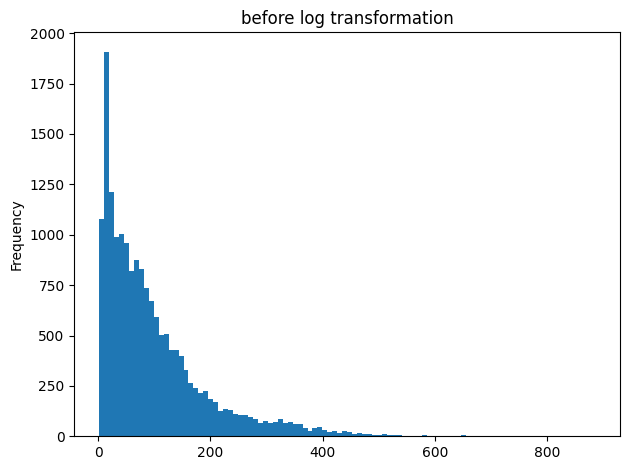

In [9]:
# Visualize the distribution of the target
df['pm2.5'].plot(kind='hist', bins=100)
plt.title('before log transformation')
plt.tight_layout()

plt.show()

Since the PM2.5 is right-skewed, we apply a log transformation to stabilize the variance and make the distribution more normal.

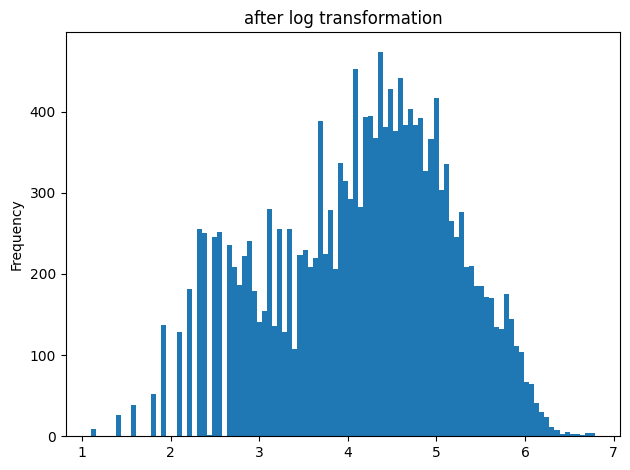

In [10]:
df['pm2.5_log'] = np.log1p(df['pm2.5'])
df['pm2.5_log'].plot(kind='hist', bins=100)
plt.title('after log transformation')
plt.tight_layout()
plt.show()

In [11]:
dl = df['pm2.5_log'].copy()
train = dl.iloc[:-24*60]
test = dl.iloc[-24*60:]

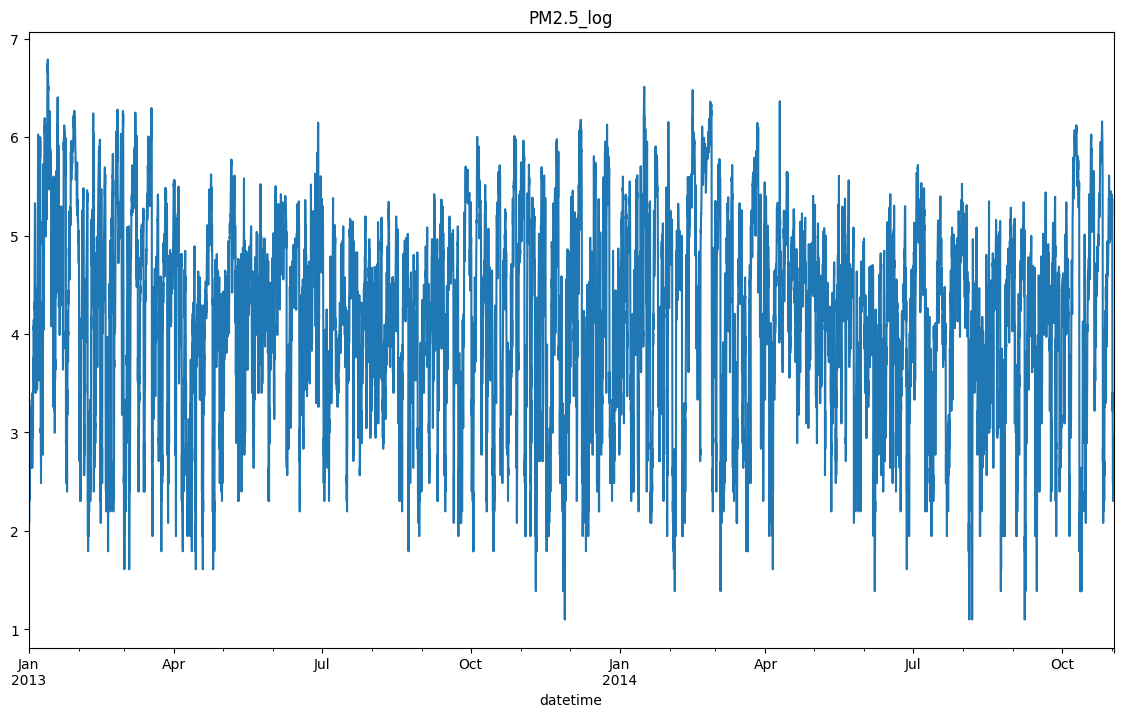

In [12]:
# Visualize the target
fig, ax = plt.subplots(figsize=(14, 8))
train.plot(ax=ax)
ax.set_title('PM2.5_log')
plt.show()

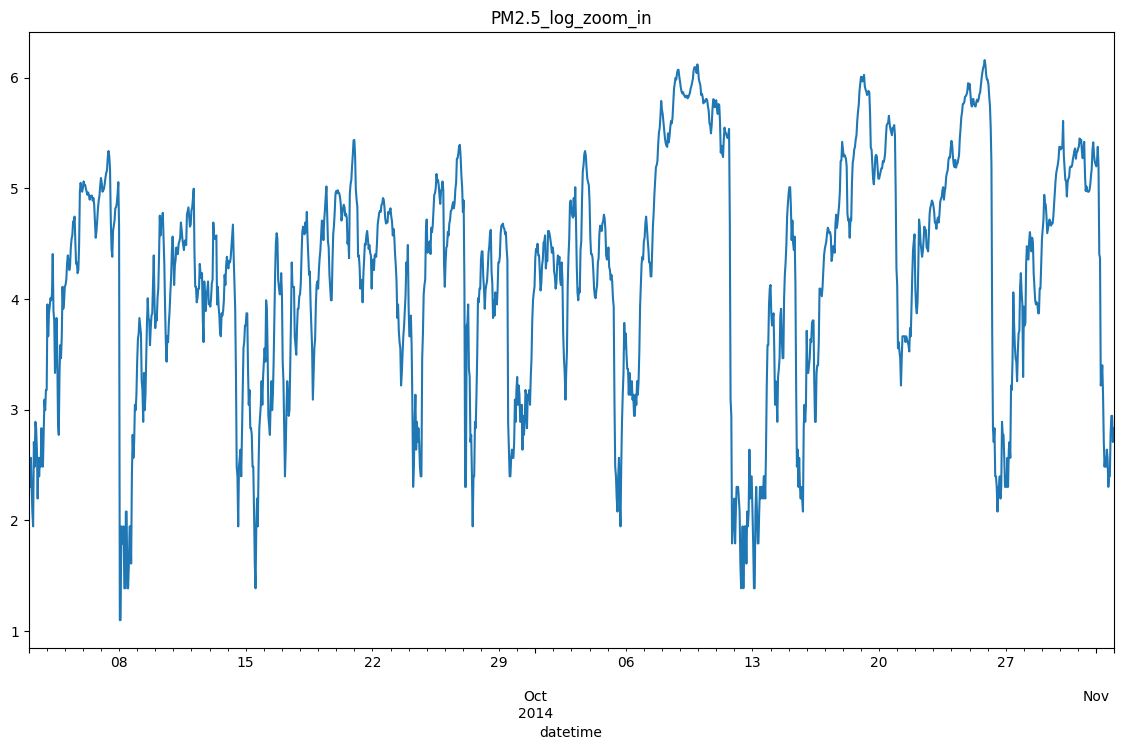

In [13]:
# Zoom in
fig, ax = plt.subplots(figsize=(14, 8))
train[-24*60:].plot(ax=ax)
ax.set_title('PM2.5_log_zoom_in')
plt.show()

## Model Selection without Exogenous Variables

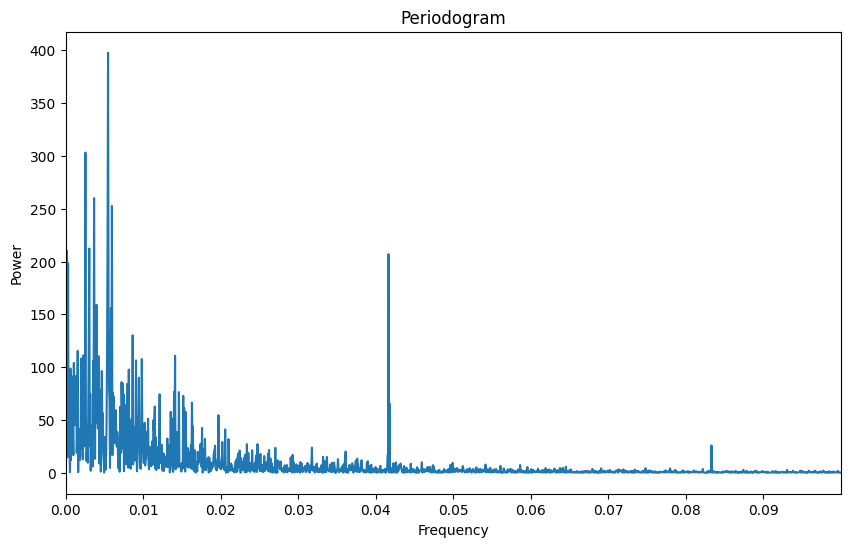

In [14]:
# Explore the seasonality

from scipy.signal import periodogram, find_peaks

# Calculate the periodogram
frequencies, power = periodogram(train)

# Plot the periodogram
plt.figure(figsize=(10,6))
plt.plot(frequencies, power)
plt.title('Periodogram')
plt.xlabel('Frequency')
plt.ylabel('Power')

plt.xticks(np.arange(0, 0.1, step=0.01))
plt.xlim(0, 0.1)
plt.show()


Since we focus on the short-term forecast, 0.042 corresponds to the short period 1/0.042 ~ 24 h. This is exactly what we expect, so we take the period as 24.

In [15]:
train_diff = train.diff(24).dropna()

In [16]:
# Check stability
from statsmodels.tsa.stattools import adfuller
result1 = adfuller(train_diff)
print('ADF Statistic: %f' % result1[0])
print('p-value: %f' % result1[1])

ADF Statistic: -24.455059
p-value: 0.000000


Based on the ADF test, we can see that this series is stationary.

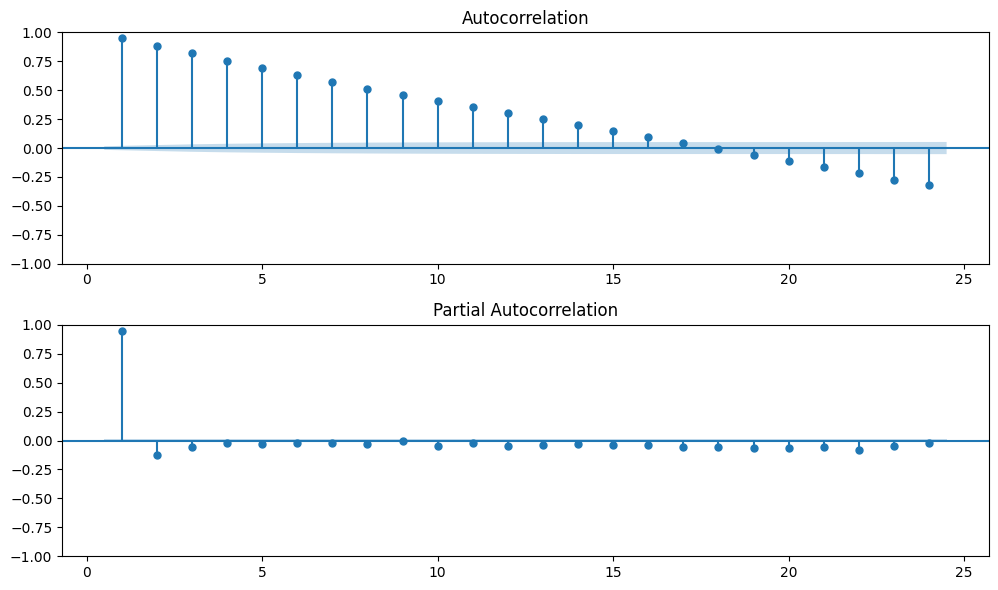

In [16]:
# Plot ACF and PACF to identify the order of SARIMA

fig, axs = plt.subplots(2,1, figsize=(10, 6))
plot_acf(train_diff, ax=axs[0], zero=False, lags=24)
plot_pacf(train_diff, ax=axs[1], zero=False, lags=24)
plt.tight_layout()
plt.show()

ACF tails off and PACF cuts off at lag 1 or 2, so we may take p=1 or 2, q=0.

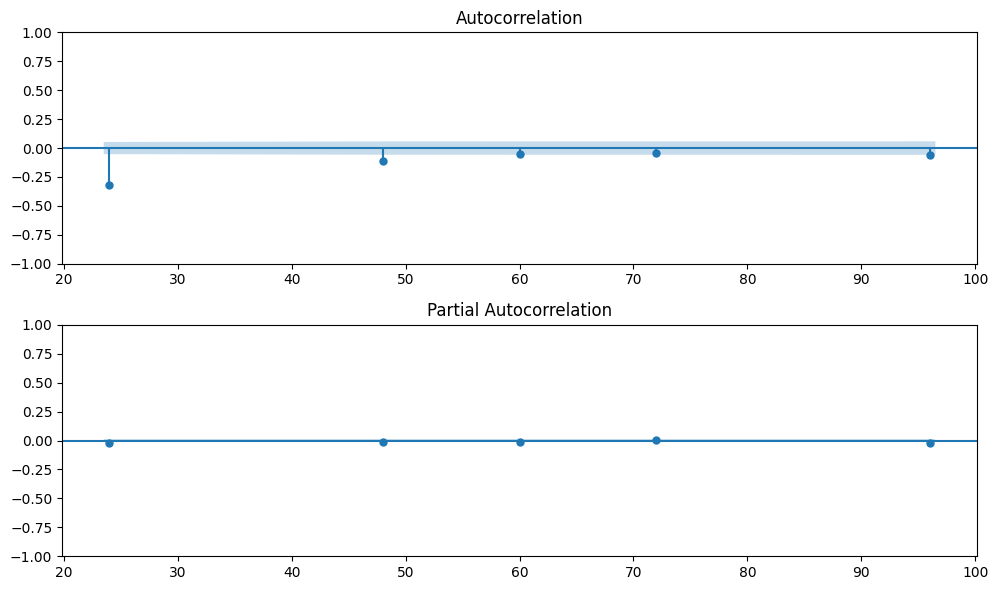

In [18]:
# Identify P and Q for the seasonal part

lags=[24, 48, 60, 72, 96]
fig, axs = plt.subplots(2,1, figsize=(10, 6))
plot_acf(train_diff, ax=axs[0], zero=False, lags=lags)
plot_pacf(train_diff, ax=axs[1], zero=False, lags=lags)

plt.tight_layout()
plt.show()

ACF cuts off at lag 1, and PACF is flat. We may take P=0, and Q=1.

Now, let's verify the potential models we inferred.

In [23]:
# Order (1,0,0) (0,1,1, 24)

# Fit the SARIMAX model without exogenous variables
model_1 = SARIMAX(train, order=(1, 0, 0), seasonal_order=(0, 1, 1, 24))
results_1 = model_1.fit()

# Print the summary of the model
print(results_1.summary())

                                      SARIMAX Results                                       
Dep. Variable:                            pm2.5_log   No. Observations:                16080
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 24)   Log Likelihood               -1416.915
Date:                              Thu, 26 Sep 2024   AIC                           2839.830
Time:                                      13:31:46   BIC                           2862.882
Sample:                                  01-01-2013   HQIC                          2847.453
                                       - 11-01-2014                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9637      0.002    458.068      0.000       0.960       0.968
ma.S.L24      -0.99

In [14]:
# Order (2,0,0) (0,1,1, 24)

# Fit the SARIMAX model without exogenous variables
model_2 = SARIMAX(train, order=(2, 0, 0), seasonal_order=(0, 1, 1, 24))
results_2 = model_2.fit()

# Print the summary of the model
print(results_2.summary())

                                      SARIMAX Results                                       
Dep. Variable:                            pm2.5_log   No. Observations:                16080
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 24)   Log Likelihood               -1315.369
Date:                              Thu, 26 Sep 2024   AIC                           2638.739
Time:                                      13:43:13   BIC                           2669.474
Sample:                                  01-01-2013   HQIC                          2648.902
                                       - 11-01-2014                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0720      0.005    230.265      0.000       1.063       1.081
ar.L2         -0.11

In terms of AIC, we can see that the best order is (2,0,0) (0,1,1, 24)

## Prediction and Evaluation Part 1



In [ ]:
optimized_results = results_2
# Generate predictions on the known dataset for evaluation
dynamic_prediction = optimized_results.get_prediction(start=-12, dynamic=True)

# Extract prediction mean
mean_prediction = dynamic_prediction.predicted_mean.values

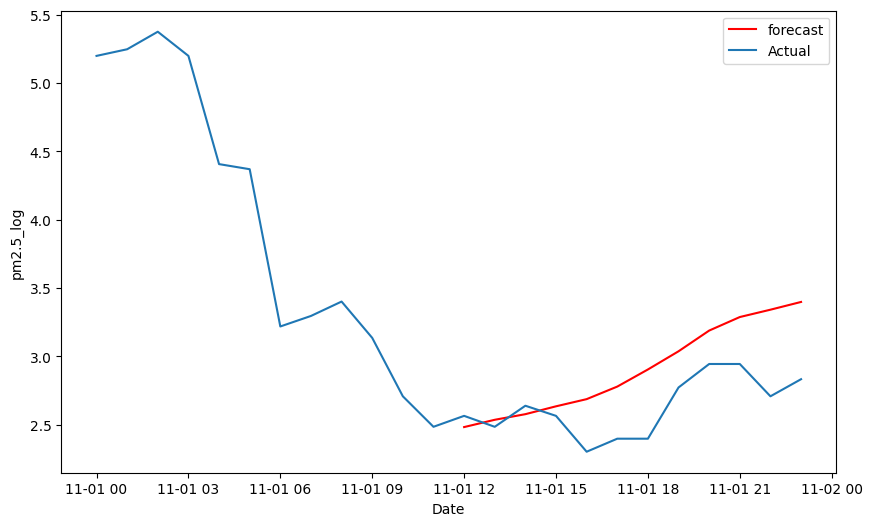

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
# plot your mean forecast
plt.plot(train.index[-12:],mean_prediction, color='r', label='forecast')

plt.plot(train[-24:], label='Actual')


# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('pm2.5_log')
plt.legend()
plt.show()

In [ ]:
# Evaluation
mae = mean_absolute_error(mean_prediction, train[-12:].values)
mse = mean_squared_error(mean_prediction, train[-12:].values)
print(f'mae: {mae}')
print(f'mse: {mse}')

mae: 0.29905756579500226
mse: 0.1280395502904864


## Selected Model with Exogenous Variables

In [ ]:
# Define the exogenous variables
exogs = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv']

# Data Preprocessing
train = df.iloc[:-24*60]
test = df.iloc[-24*60:]

train_main = train['pm2.5_log']
test_main = test['pm2.5_log']

train_exog = train[exogs]
test_exog = test[exogs]

scaler_exog = MinMaxScaler()
train_exog_scaled = scaler_exog.fit_transform(train_exog)
test_exog_scaled = scaler_exog.transform(test_exog)

In [ ]:
# Fitting
exog_model = SARIMAX(train_main, order=(2, 0, 0), seasonal_order=(0, 1, 1, 24), exog=train_exog_scaled)
results = exog_model.fit()

# Print the summary of the model
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                            pm2.5_log   No. Observations:                16080
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 24)   Log Likelihood               -1173.959
Date:                              Sun, 22 Sep 2024   AIC                           2373.918
Time:                                      11:33:51   BIC                           2473.808
Sample:                                  01-01-2013   HQIC                          2406.950
                                       - 11-01-2014                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.0381      0.068     30.142      0.000       1.906       2.171
x2            -0.37

Clearly, in terms of AIC, this model gets a higher score than the previous models.

## Prediction and Evaluation Part 2

In [ ]:
# Generate predictions
prediction_exog = results.get_prediction(start=-12, dynamic=True)
prediction_exog_mean = prediction_exog.predicted_mean.values

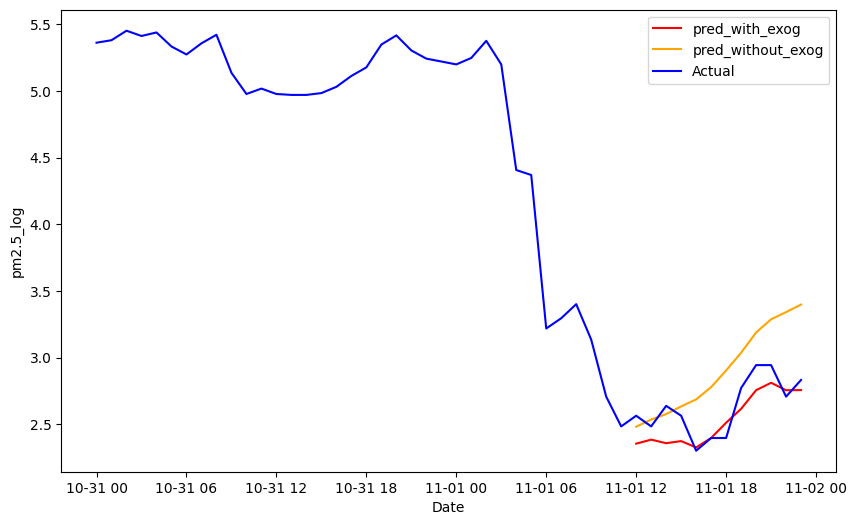

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
# plot your mean forecast
plt.plot(train_main.index[-12:],prediction_exog_mean, color='r', label='pred_with_exog')
plt.plot(train_main.index[-12:],mean_prediction, color='orange', label='pred_without_exog')

plt.plot(train_main[-48:], color='blue', label='Actual')


# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('pm2.5_log')
plt.legend()
plt.show()

In [ ]:
# Evaluation
mae_e = mean_absolute_error(prediction_exog_mean,train_main[-12:].values)
mse_e = mean_squared_error(prediction_exog_mean, train_main[-12:].values)
print(f'mae: {mae_e}')
print(f'mse: {mse_e}')

mae: 0.12659962419944681
mse: 0.022291463325081463


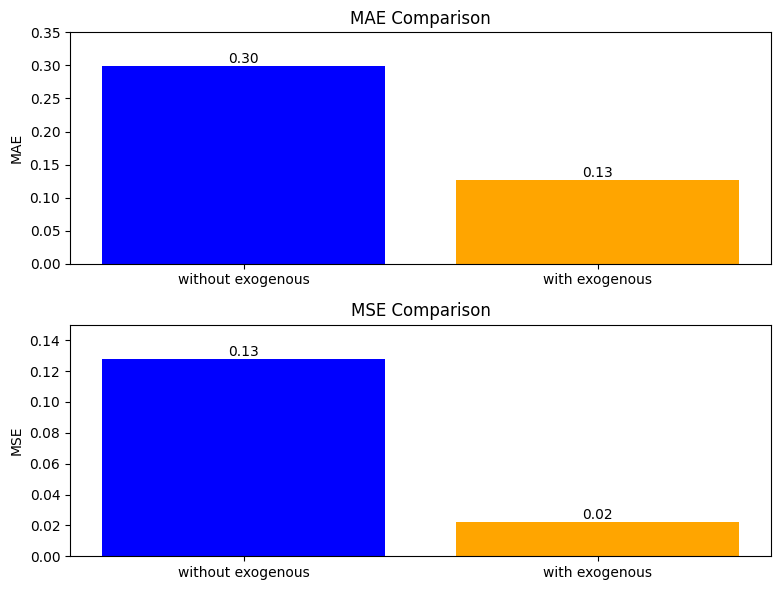

In [ ]:
colors = ['blue', 'orange']

fig, axs = plt.subplots(2,1,figsize=(8, 6))

mae_values = [mae, mae_e]
mse_values = [mse, mse_e]

bars = axs[0].bar(['without exogenous',  'with exogenous'], mae_values, color=colors)
axs[0].set_ylabel('MAE')
axs[0].set_title('MAE Comparison')
axs[0].bar_label(bars, fmt='%.2f')
axs[0].set_ylim(0, 0.35)


bars = axs[1].bar(['without exogenous',  'with exogenous'], mse_values, color=colors)
axs[1].set_ylabel('MSE')
axs[1].set_title('MSE Comparison')
axs[1].bar_label(bars,fmt='%.2f')
axs[1].set_ylim(0, 0.15)

plt.tight_layout()
plt.show()

By incorporating exogenous variables into the model, we achieved lower MAE and MSE compared to the model without exogenous variables.

On test set

## Summary

Including exogenous variables has been shown to significantly improve the model's performance. While this project primarily demonstrates how to predict time series with exogenous variables using SARIMAX, there are numerous strategies we can employ to further enhance the model's accuracy. These include implementing the pmdarima library to automatically optimize the order of SARIMA, exploring alternative models such as LSTM, XGBoost, or leveraging libraries like PyCaret for automated machine learning. Additionally, model performance can be refined by incorporating more relevant variables, removing non-relevant ones, and experimenting with various feature transformations. By combining these methods, we can ensure a more robust and accurate predictive model.